In [1]:
from datetime import datetime, timedelta
import bz2
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from intervaltree import IntervalTree, Interval
from iso8601 import parse_date

from satbazaar import db

In [2]:
mpl.rcParams['font.size'] = 14

In [3]:
# script 'get-observations.py' generates this file
observations = db.load_observations()

In [4]:
tree = IntervalTree()

# count the bad obs start/end times
non_causal = 0
zero_duration = 0
for o in observations.values():
    start = parse_date(o['start'], default_timezone=None)
    end = parse_date(o['end'], default_timezone=None)
    
    # ignore bogus start/end times
    if end < start:
        non_causal += 1
        continue
    elif end == start:
        zero_duration += 1
        continue
    tree.addi(start, end, o)

print(zero_duration, 'zero duration')
print(non_causal, 'start > end')

68 zero duration
64 start > end


In [5]:
len(tree)

185655

In [6]:
firstday = tree.begin().replace(hour=0, minute=0, second=0)
lastday = tree.end().replace(hour=0, minute=0, second=0)


days = [firstday + timedelta(days=i) for i in range(0, (lastday - firstday).days +1, 1)]
print(firstday)
print(lastday)
len(days)

2015-10-12 00:00:00+00:00
2018-07-29 00:00:00+00:00


1022

In [7]:
total = []
good = []
bad = []
failed = []
unknown = []
duration = []
d = timedelta(seconds=0)

oneday = timedelta(days=1)
for i, day in enumerate(days):
    obs = tree[day : day + oneday]
    count = dict(total=0, good=0, bad=0, failed=0, unknown=0)
    d = timedelta(seconds=0)
    for o in obs:
        count[o.data['vetted_status']] += 1
        count['total'] += 1
        d += o.end - o.begin
    total.append(count['total'])
    good.append(count['good'])
    bad.append(count['bad'])
    failed.append(count['failed'])
    unknown.append(count['unknown'])
    duration.append(d)


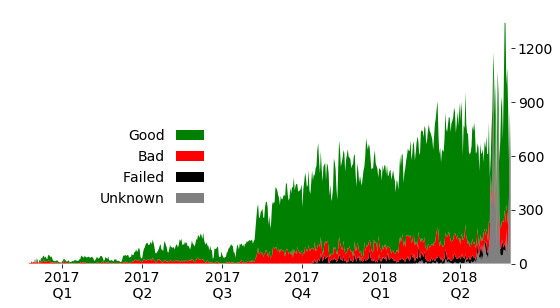

In [8]:
fig, ax = plt.subplots(figsize=(8, 4.5))

#ax.plot(days, total, '-k', label='Total', alpha=0.8)
#ax.plot(days, good, '-g', label='Good')
#ax.plot(days, bad, '-r', label='Bad')
#ax.plot(days, failed, '-c', label='Failed')
#ax.plot(days, unknown, '-m', label='Unknown')


lines = ax.stackplot(
    days,
    (unknown, failed, bad, good),
    labels=reversed(('Good', 'Bad', 'Failed', 'Unknown')),
    colors=('grey', 'k', 'r', 'g'),
)
#plt.setp(lines, alpha=0.9)

#ax.set_title(
#    'SatNOGS Network\nObservations per day',
#    va='top',
#    #ha='left',
#    #loc='left',
#    pad=-10,
#)

# stackplot reverses the legend order :(
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    loc='lower right',
    bbox_to_anchor=(0.4, 0.2),
    frameon=False,
    markerfirst=False,
    borderpad=0,
)

#fig.autofmt_xdate()
ax.xaxis.set_major_locator(mpl.dates.MonthLocator(interval=3))
#ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
def quarter_formatter(x, pos):
    d = mpl.dates.num2date(x)
    q = ((d.month - 1) // 3) + 1
    if True: #q % 2 == 1:
        s = '{}\n Q{} '.format(d.year, q)
    else:
        s = ''
    return s

ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(quarter_formatter))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=0, ha='center', va='top')

ax.set_xlim(left=datetime(2017, 1, 1), right=days[-1])

ax.yaxis.tick_right()
ax.set_yticks(range(0, 1500, 300))
ax.set_ylim(bottom=0)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()

fig.savefig('network-obs-day.png', dpi=300)

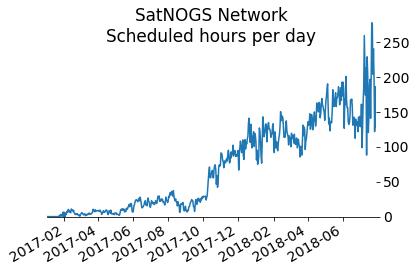

In [9]:
fig, ax = plt.subplots()

access = np.fromiter((d.total_seconds() for d in duration), np.float, len(duration))

ax.plot(days, access/(60*60))

ax.set_title(
    'SatNOGS Network\nScheduled hours per day',
    va='top',
)

fig.autofmt_xdate()
ax.set_xlim(
    left=datetime(2017, 1, 1),
    right=days[-1],
)

ax.yaxis.tick_right()
ax.set_ylim(bottom=0)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

plt.tight_layout()

#fig.savefig('network-obs-access.png', dpi=150)

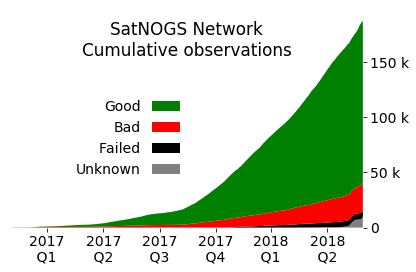

In [10]:

fig, ax = plt.subplots()

#ax.plot(days, total, '-k', label='Total', alpha=0.8)
#ax.plot(days, good, '-g', label='Good')
#ax.plot(days, bad, '-r', label='Bad')
#ax.plot(days, failed, '-c', label='Failed')
#ax.plot(days, unknown, '-m', label='Unknown')


lines = ax.stackplot(
    days,
    (np.cumsum(unknown), np.cumsum(failed), np.cumsum(bad), np.cumsum(good)),
    labels=reversed(('Good', 'Bad', 'Failed', 'Unknown')),
    colors=('grey', 'k', 'r', 'g'),
)
#plt.setp(lines, alpha=0.8)

ax.set_title(
    'SatNOGS Network\nCumulative observations',
    va='top',
    #ha='left',
    #loc='left',
    pad=-10,
)

# stackplot reverses the legend order :(
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    loc='lower right',
    bbox_to_anchor=(0.5, 0.2),
    frameon=False,
    markerfirst=False,
    borderpad=0,
)

#fig.autofmt_xdate()
ax.xaxis.set_major_locator(mpl.dates.MonthLocator(interval=3))
#ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
def quarter_formatter(x, pos):
    d = mpl.dates.num2date(x)
    q = ((d.month - 1) // 3) + 1
    s = '{}\n Q{} '.format(d.year, q)
    return s

ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(quarter_formatter))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=0, ha='center')

ax.set_xlim(left=datetime(2017, 1, 1), right=days[-1])

ax.yaxis.set_major_formatter(mpl.ticker.EngFormatter())
ax.yaxis.tick_right()
ax.set_ylim(bottom=0)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()

#fig.savefig('network-obs-day.png', dpi=150)